<a href="https://colab.research.google.com/github/marcinszulczyk/kaggle_titanic_solution/blob/develop/kaggle_titanic_v_0001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ranking Kaggle: 5221
# Rate Kaggle: 0.78708



# Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
import plotly.express as px
import plotly.figure_factory as ff
import missingno

import sklearn

from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

import datetime



/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



# Funkcje pomocnicze

In [2]:
def get_time():
  x = datetime.datetime.now()
  return "{}_{}_{}__{}_{}_{}".format(x.strftime("%G"),
                     x.strftime("%m"),
                     x.strftime("%d"),
                     x.strftime("%H"),
                     x.strftime("%M"),
                     x.strftime("%S"),
                     )


## Inżynieria wsteczna

In [3]:
def feature_engineering_df_all(df_train, df_test):
  df = pd.concat([df_train, df_test])
  return df

def feature_engineering_basic_Pclass(df_train, df_test):
  return feature_engineering_df_all(df_train, df_test)

## column Family Size

In [4]:
def colum_family_size_calc(df):
  df['Family_Size'] = 1 + df['SibSp'] + df['Parch']
  print (df['Family_Size'])

## column Cabin

In [5]:
def column_cabin_mask_get(df):
  df["Cabin_Data"] = df["Cabin"].isnull().apply(lambda x: not x)
  print(df["Cabin_Data"])

def column_cabin_deck_get(df):
  df['Deck'] = df['Cabin'].str.slice(0,1)
  print(df['Deck'])

def column_cabin_room_get(df):
  df['Room'] = df['Cabin'].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")
  print(df['Room'])


## column Name

In [6]:
def column_name_last_name(df):
  df['Name_LastName'] = df['Name'].map(lambda x: x.split(',')[0].lower().strip())
  print (df['Name_LastName'])
  return df

def column_name_title(df):
  df['Name_Title'] = df['Name'].map(lambda x: x.split(',')[1].split('.')[0].lower().strip())
  print (df['Name_Title'])
  return df


## Analiza danych

In [7]:
def check_column(df, name, histogram = 1, compare = 0, column_count = 0):
  size = 80
  print(" Dane kolumny: {0:s}. Typ: {1}".format(name,df[name].dtypes))
  print('-' * size)
  print("| {0:62s} | {1:>12}|".format("Ilość wartości", df[name].count()))
  print("| {0:62s} | {1:>12}|".format("Ilość wartości unikalnych", df[name].nunique()))
  print("| {0:62s} | {1:>12}|".format("Ilość wartości NaN", df[name].isna().sum()))
  print('-' * size)
  if column_count:
    pd.pivot_table(df,index = name , columns=compare ,values=column_count, aggfunc='count')
    print('-' * size)
  print('DESCRIBE:')
  print(df[name].describe())
  print('-' * size)
  print('VALUE COUNTS:')
  print(df[name].value_counts())
  print('-' * size)
  print('HEAD:')
  print(df[name].head())
  print('-' * size)
  if histogram:
    print('HISTOGRAM:')
    fig = px.histogram(df, x =name, width=800)
    fig.show() 
  if compare:
    # print('JOINPLOT:')
    # g = sns.jointplot(data = df, x = name, y = compare, kind = 'kde', cmap = 'rocket')
    # g.plot_joint(plt.scatter, s = 8, marker='+')
    # plt.show()
    f = sns.FacetGrid(df_train, hue=compare, aspect=4)
    f.map(sns.kdeplot,name, shade = True)

    f.set(xlim=(df_train[name].min(), df_train[name].max()))

    f.add_legend()
    plt.show()

# Pobranie danych danych

## Link do Kaggle

https://www.kaggle.com/c/titanic/overview

## Wczytanie danych

In [8]:
df_train = pd.read_csv("https://raw.githubusercontent.com/marcinszulczyk/kaggle_titanic_solution/c48ff96bbfd29c691a78a0e46e3dc2abaeec65c1/data/train.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/marcinszulczyk/kaggle_titanic_solution/c48ff96bbfd29c691a78a0e46e3dc2abaeec65c1/data/test.csv")

In [9]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [10]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## Połączenie zbiorów danych

Łączę zbiory danych tak aby operacje wykonywane na kolumnach były spójne.

Przed uruchomieniem ML zbiory zostaną rozdzielone przy użyciu kolumny *Survived*

In [57]:
df_all = feature_engineering_df_all(df_train, df_test)

## Podstawowe informacje o danych

### Opis kolumn


---


**PassengerId**  

ID pasażera


---

**Survived**

Czy pasażer został uratowany

0 - nie został uratowany

1 - został uratowany

---

**Pclass**

Klasa jaką podróżował pasażer

1 - Pierwsza klasa (najwyższy standard)

2 - Druga klasa

3 - Trzecia klasa (najniższy standard)

---

**Name** 

Imię pasażera

Imię, nazwisto, tytuł itp.

---

**Sex**        

Płeć pasażera

male - mężczyzna

female - kobieta

---

**Age**          

Wiek pasażera

Jeżeli było dziecko ale nie miało rodziców to oznaczało, że podróżowało z nianią.

---

**SibSp**

Ilość rodzeństwa na pokładzie - bracia, siostry itp.

---

**Parch**

Ilość rodziców na pokładzie

---

**Ticket**

Numer biletu

---

**Fare**

Koszt biletu

---

**Cabin**

Przedział na statku

---

**Embarked**

Port rozpoczęcia podróży

C - Cherbourg

Q - Queenstown

S - Southampton

---

### Wyświetlenie przykłądowych danych

In [58]:
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### Wyświetlenie podstawowych informacji o kolumnach

In [59]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


### Wyświetlenie podstawowych statystyk kolumn

In [60]:
df_all.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


### Wyświetlenie informacji o brakujących danych

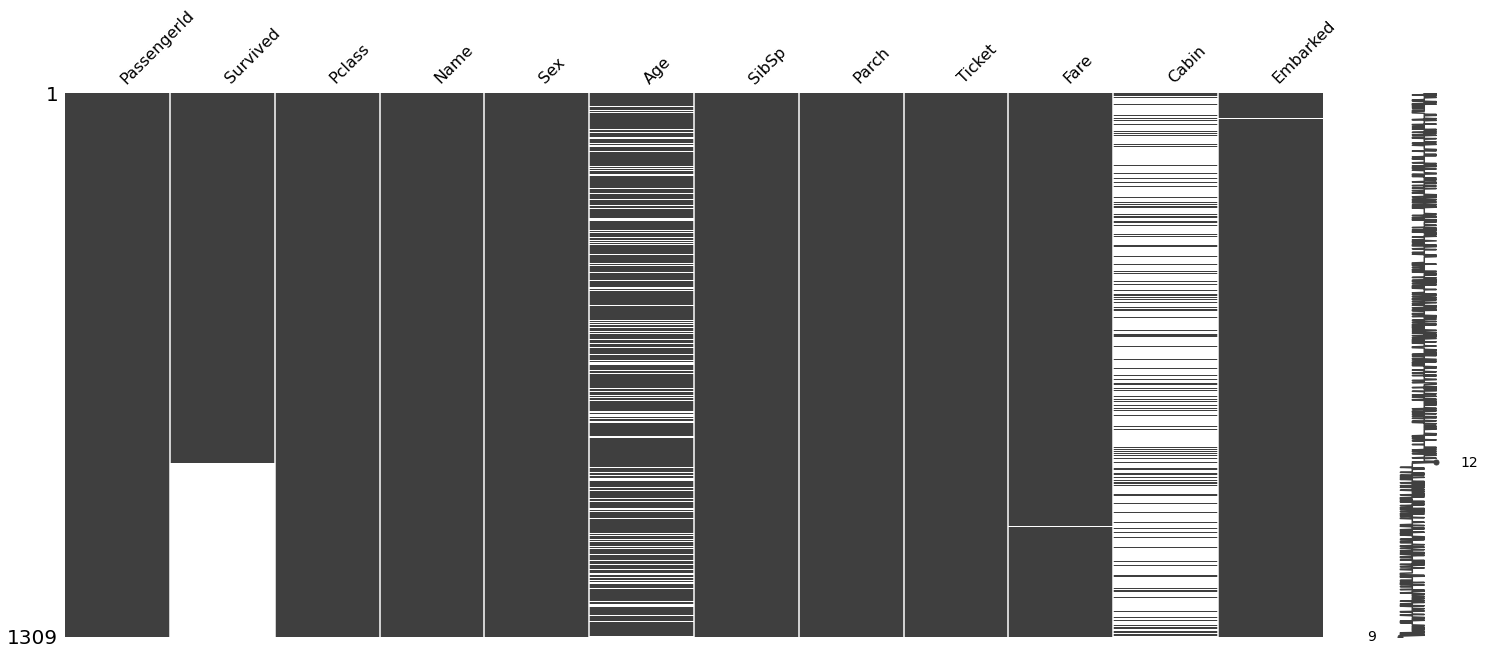

In [61]:
missingno.matrix(df_all)

# Analiza danych - Wstępne zapoznanie się z danymi

## Założenia analizy

W tym kroku analizowane będą poszczególne kolumny zbioru danych. 

Podstawowym celem jest zdobycie jak najszerszej wiedzy na temat każdej z kolum, w razie potrzeby zdobycie dodatkowej wiedzy eksperckiej i wskazanie w jaki sposób można przygotować dane do dalszej analizy.

W tym punkcie skupiam się na następujących zagadnieniach:

- określeniu typu zmiennej
- określeniu brakujących danych
- wyszukaniu źródeł wiedzy eksperckiej i wskazaniu jak można jej użyć
- określenie typu zawartych danych - czy są to wartości liczbowe czy kategoryczne


## Column: Survived

### Column Survived: Posumowanie

Ze względu na fakt, że kolumna ta występuje tylko w zbiorze train do analizy używam *df_train*.

Możemy zauważyć, że:

*   kolumna nie ma wartości nieokreślonych
*   kolumna jest typu int64
*   kolumna posiada dwie wartości unikalne

Z opisu kolumny przechowuje ona informaję o tym czy osoba została uratowanana czy nie. Podczas dalszej analizy kolumna będzie traktowana jako wartość kategoryczna. 

Nie ma potrzeby kodowania i standaryzowania wartości - wartości w kolumnie mają wartość 0 i 1.



### Column Survived: Analiza

In [62]:
column_name = 'Survived'
check_column(df_train, column_name)

 Dane kolumny: Survived. Typ: int64
--------------------------------------------------------------------------------
| Ilość wartości                                                 |          891|
| Ilość wartości unikalnych                                      |            2|
| Ilość wartości NaN                                             |            0|
--------------------------------------------------------------------------------
DESCRIBE:
count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64
--------------------------------------------------------------------------------
VALUE COUNTS:
0    549
1    342
Name: Survived, dtype: int64
--------------------------------------------------------------------------------
HEAD:
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64
-----------------------------------------------------------------

## Column: Pclass

### Column Pclass: Posumowanie

Ze względu na fakt, że kolumna ta występuje w obu zbiorach danych do analizy używam *df_all*

Możemy zauważyć, że:

*   kolumna nie ma wartości nieokreślonych
*   kolumna jest typu int64
*   kolumna posiada trzy wartości unikalne

Z opisu kolumny wynika, że przechowuje ona informaję o klasie jaką podróżuje pasażer.

W kolumnie występują trzy wartości typu int64 więc nie ma potrzeby kodowania i standaryzacji wartości.

Możemy zauważyć, że rozkład pomiędzy klasami jest następujący:

*   ilość osób w klasie 1(323 osoby) i 2(277 osób) jest zbliżona
*   ilość osób w klasie 3(709) jest większa niż suma osób w klasach 1 i 2 (600osób)


### Column Pclass: Wiedza ekspercka
https://www.encyclopedia-titanica.org/


https://www.encyclopedia-titanica.org/class-gender-titanic-disaster-1912~chapter-2~part-2.html

Na powyższych stronach dostępne są plany i opisy klas na statku.



### Column Pclass: Analiza

In [63]:
column_name    = 'Pclass'
column_count   = 'Ticket'
check_column(df_all, column_name)

 Dane kolumny: Pclass. Typ: int64
--------------------------------------------------------------------------------
| Ilość wartości                                                 |         1309|
| Ilość wartości unikalnych                                      |            3|
| Ilość wartości NaN                                             |            0|
--------------------------------------------------------------------------------
DESCRIBE:
count    1309.000000
mean        2.294882
std         0.837836
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         3.000000
Name: Pclass, dtype: float64
--------------------------------------------------------------------------------
VALUE COUNTS:
3    709
1    323
2    277
Name: Pclass, dtype: int64
--------------------------------------------------------------------------------
HEAD:
0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: int64
--------------------------------------------------------

## Column Name

### Column Name: Posumowanie

Ze względu na fakt, że kolumna ta występuje w obu zbiorach danych do analizy używam *df_all*

Możemy zauważyć, że:

*   kolumna nie ma wartości nieokreślonych
*   kolumna jest typu object
*   kolumna posiada 1307 wartości unikalne z 1309 (jest możliwe, że dwie osoby mają to samo imię i nazwisko)

Z opisu kolumny wynika, że przechowuje ona informaję o podstawowych danych osobowych pasażera.

Z kolumny wyodrębnimy dane dotyczące nazwiska i zwrotu grzecznościowego co moze być przydatne do dalszej analizy.





### Column Name: Wiedza ekspercka

---

Na podstawie opisu ze strony:

https://www.kaggle.com/c/titanic/discussion/2885

Using the example:

Baclini, Mrs. Solomon (Latifa Qurban)

Mrs. indicates that she is married

Solomon is the name of her husband. This is a (old-ish) custom where wives can be referred to by their husbands name. For instance, if Jane Smith was married to John Smith, she could be referred to as Mrs. John Smith.

Latifa is her first name.

Qurban is her "maiden" name. This is the family/last name that she had before getting married.

Baclini is her (married) family/last name, i.e. the last name of her husband Solomon.

For the example

Baclini, Miss. Marie Catherine (daughter of above)

Miss indicates that she is unmarried, so parsing into first/last names becomes a bit easier.

In this case Marie is her first name, Catherine is her middle name and Baclini is the family/last name.

---

Podsumowując kolumna składa się z następujących elementów:

*    Nazwiska - pozwoli na zgrupowanie rodzin
*    Tytułu - zwrotu grzecznościowego - pozwoli na określeniu czy dana osoba jest dzieckiem czy dorosłym, ewentualie statusu społecznego osoby
*    oraz imię, nazwisko rodowe itp

---

W ramach prac nad tą kolumną wyodrębnimy dwa elementy jako nowe kolumny:

*    Nazwisko
*    Tytuł


---

### Column Name: Analiza

In [64]:
column_name    = 'Name'
column_count   = 'Ticket'
check_column(df_all, column_name, histogram=0)

 Dane kolumny: Name. Typ: object
--------------------------------------------------------------------------------
| Ilość wartości                                                 |         1309|
| Ilość wartości unikalnych                                      |         1307|
| Ilość wartości NaN                                             |            0|
--------------------------------------------------------------------------------
DESCRIBE:
count                 1309
unique                1307
top       Kelly, Mr. James
freq                     2
Name: Name, dtype: object
--------------------------------------------------------------------------------
VALUE COUNTS:
Kelly, Mr. James                     2
Connolly, Miss. Kate                 2
Masselmani, Mrs. Fatima              1
Sage, Miss. Dorothy Edith "Dolly"    1
Pengelly, Mr. Frederick William      1
                                    ..
Stankovic, Mr. Ivan                  1
Honkanen, Miss. Eliina               1
Johanson, M

---

### Column Name: Wyodrębnienie Nazwiska

In [65]:
#df_all = column_name_last_name(df_all)
df_all['Name_LastName'] = df_all['Name'].map(lambda x: x.split(',')[0].lower().strip())
print ("Ilość wartości unikalnych: {}".format(df_all['Name_LastName'].nunique()))
print (df_all['Name_LastName'])

Ilość wartości unikalnych: 875
0             braund
1            cumings
2          heikkinen
3           futrelle
4              allen
           ...      
413          spector
414    oliva y ocana
415          saether
416             ware
417            peter
Name: Name_LastName, Length: 1309, dtype: object


---

### Column Name: Wyodrębnienie Zwrotu grzecznościowego

In [66]:
#df_all = column_name_title(df_all)
df_all['Name_Title'] = df_all['Name'].map(lambda x: x.split(',')[1].split('.')[0].lower().strip())
print ("Ilość wartości unikalnych: {}".format(df_all['Name_Title'].nunique()))
print (df_all['Name_Title'])

Ilość wartości unikalnych: 18
0          mr
1         mrs
2        miss
3         mrs
4          mr
        ...  
413        mr
414      dona
415        mr
416        mr
417    master
Name: Name_Title, Length: 1309, dtype: object


---

### Column Name: Wyświetlenie zbioru danych

In [67]:
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_LastName,Name_Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,braund,mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,cumings,mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,heikkinen,miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,futrelle,mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,allen,mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,spector,mr
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,oliva y ocana,dona
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,saether,mr
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,ware,mr


---

## Column Name_LastName


---

### Column Name_LastName: Posumowanie

Kolumna ta zawiera nazwiska osób podróżujących.

Możemy jej użyć do określenia przynależności do danej rodziny.

Na ten moment kolumna bez zmian.

---

### Column Name_LastName: Wiedza ekspercka

Brak opracowania

---

### Column Name_LastName: Analiza

In [68]:
column_name    = 'Name_LastName'
check_column(df_all, column_name, histogram=0)

 Dane kolumny: Name_LastName. Typ: object
--------------------------------------------------------------------------------
| Ilość wartości                                                 |         1309|
| Ilość wartości unikalnych                                      |          875|
| Ilość wartości NaN                                             |            0|
--------------------------------------------------------------------------------
DESCRIBE:
count     1309
unique     875
top       sage
freq        11
Name: Name_LastName, dtype: object
--------------------------------------------------------------------------------
VALUE COUNTS:
sage         11
andersson    11
asplund       8
goodwin       8
davies        7
             ..
mellors       1
moussa        1
adams         1
ohman         1
byles         1
Name: Name_LastName, Length: 875, dtype: int64
--------------------------------------------------------------------------------
HEAD:
0       braund
1      cumings
2    heikkine

---

## Column Name_Title

---

### Column Name_Title: Posumowanie

Informacje z wiedzy eksperckiej pozwolą nam na określenie kim są osoby podróżujące.

Jest to ważne w kontekscie grup o małej liczebności (1 - 8) które można powiązać z innymi tytułami.

Docelowo można połączyć ustandaryzować dane i tytuły dodając jednocześnie kolumny z informacją o pochodzeniu sclacheckim, byciu naukowcem, osobą duchowną lub wojskowym.

Na tym etapie zostawimy te informacje bez zmian.

Kolumna ta pomoże określić brakujące dane z kolumny *Age*. Brakujące dane dla danego tytułu bedą uzupełnione jako mediana dla tego tytułu.


---

### Column Name_Title: Wiedza ekspercka

Znaczenie tytułów:

---

Mr - Mister, zwykle napisany w formie kontraktowej Mr. (USA) lub Mr (UK), jest powszechnie używanym angielskim tytułem honorowym dla mężczyzn w randze rycerskiej.

---

Miss jest zwrotem angielskim honorowym, tradycyjnie używanym tylko dla niezamężnych kobiet 

---

Mrs to powszechnie używany zwrot dla kobiet zamężnych

---

Master jest używany w stosunku do chłopców i młodych mężczyzn.

---

Dr to tytuł naukowy 

---

Rev - Wielebny to tytuł używany przed imieniem lub stopniem oficjalnie mianowanego przywódcy religijnego

---

col - colonel to starszy oficer wojskowy

---

ms - domyślny sposób zwracania się do kobiet bez względu na stan cywilny

---

major - colonel to starszy oficer wojskowy

---

mlle - Mademoiselle to francuski tytuł kurtuazyjny, w skrócie Mlle, tradycyjnie nadawany niezamężnej kobiecie. 

--- 

don/dona - tytuł grzecznościowy używany w Hiszpanii, Włoszech oraz Portugalii (dom), tylko w połączeniu z imieniem. W średniowieczu używali go członkowie rodziny królewskiej oraz książęta, z czasem rozszerzony na szlachtę i duchowieństwo. Tytuł ten przyjmuje formę żeńską, w języku hiszpańskim doña, włoskim donna i portugalskim dona.

---

lady - Słowo dama to określenie szacunku dla dziewczyny lub kobiety, odpowiednika dżentelmena. Kiedyś określano je tylko kobietami o wysokiej klasie społecznej lub statusie, żeńskim odpowiednikiem pana, teraz może odnosić się do każdej dorosłej kobiety.

---

mme - Termin pochodzi od francuskiej madame. W języku francuskim ma dame oznacza dosłownie „moja pani”. Tytuł szlachecki.

---

sir to oficjalny angielski adres honorowy dla mężczyzn, wywodzący się od Sire w późnym średniowieczu. Tradycyjnie, zgodnie z prawem i zwyczajem, Sir jest używany do mężczyzn utytułowanych rycerzami

---

Jonkheer - (odpowiednik żeński: jonkvrouw; francuski: Écuyer, angielski: Squire) to zaszczytny tytuł w Niderlandach, oznaczający najniższą rangę wśród szlachty

---

the countess - Count - Hrabia (countess  oznacza hrabina) to historyczny tytuł szlachecki w niektórych krajach europejskich, różniący się statusem względnym, generalnie o średniej randze w hierarchii szlacheckiej

--- 

capt- kapitan

---

Linki:

https://en.wikipedia.org/wiki/Mr.

https://en.wikipedia.org/wiki/Miss

https://en.wikipedia.org/wiki/Mrs.

https://en.wikipedia.org/wiki/Doctor_(title)

https://www.collinsdictionary.com/dictionary/english/reverend

https://en.wikipedia.org/wiki/Colonel

https://en.wikipedia.org/wiki/Ms.

https://en.wikipedia.org/wiki/Major

https://pl.wikipedia.org/wiki/Don_(tytulatura)

https://en.wikipedia.org/wiki/Lady


https://en.wikipedia.org/wiki/Madam

https://en.wikipedia.org/wiki/Sir

https://en.wikipedia.org/wiki/Jonkheer

https://en.wikipedia.org/wiki/Count

---

### Column Name_Title: Analiza

In [69]:
column_name    = 'Name_Title'
check_column(df_all, column_name, histogram=0)

 Dane kolumny: Name_Title. Typ: object
--------------------------------------------------------------------------------
| Ilość wartości                                                 |         1309|
| Ilość wartości unikalnych                                      |           18|
| Ilość wartości NaN                                             |            0|
--------------------------------------------------------------------------------
DESCRIBE:
count     1309
unique      18
top         mr
freq       757
Name: Name_Title, dtype: object
--------------------------------------------------------------------------------
VALUE COUNTS:
mr              757
miss            260
mrs             197
master           61
dr                8
rev               8
col               4
major             2
mlle              2
ms                2
dona              1
the countess      1
capt              1
jonkheer          1
lady              1
don               1
sir               1
mme               1

In [70]:
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_LastName,Name_Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,braund,mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,cumings,mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,heikkinen,miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,futrelle,mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,allen,mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,spector,mr
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,oliva y ocana,dona
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,saether,mr
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,ware,mr


---

## Column Sex

---

### Column Sex: Posumowanie

Płeć osoby. Brak operacji na tej kolumnie

---

### Column Sex: Wiedza ekspercka

Brak opracowania

---

### Column Sex: Analiza

In [71]:
column_name    = 'Sex'
check_column(df_all, column_name, histogram=1)

 Dane kolumny: Sex. Typ: object
--------------------------------------------------------------------------------
| Ilość wartości                                                 |         1309|
| Ilość wartości unikalnych                                      |            2|
| Ilość wartości NaN                                             |            0|
--------------------------------------------------------------------------------
DESCRIBE:
count     1309
unique       2
top       male
freq       843
Name: Sex, dtype: object
--------------------------------------------------------------------------------
VALUE COUNTS:
male      843
female    466
Name: Sex, dtype: int64
--------------------------------------------------------------------------------
HEAD:
0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object
--------------------------------------------------------------------------------
HISTOGRAM:


---

## Column Age

---

### Column Age: Posumowanie

---

### Column Age: Wiedza ekspercka

---

### Column Age: Analiza

In [72]:
column_name    = 'Age'
check_column(df_all, column_name, histogram=1)

 Dane kolumny: Age. Typ: float64
--------------------------------------------------------------------------------
| Ilość wartości                                                 |         1046|
| Ilość wartości unikalnych                                      |           98|
| Ilość wartości NaN                                             |          263|
--------------------------------------------------------------------------------
DESCRIBE:
count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64
--------------------------------------------------------------------------------
VALUE COUNTS:
24.00    47
22.00    43
21.00    41
30.00    40
18.00    39
         ..
76.00     1
22.50     1
74.00     1
80.00     1
0.67      1
Name: Age, Length: 98, dtype: int64
--------------------------------------------------------------------------------
HEAD:
0    22.

---

## Column SibSp & Parch

---

### Column SibSp & Parch: Posumowanie

Suma tych kolum + 1 posłuży do wyznaczenia wielkości rodziny na statku

---

### Column SibSp & Parch: Wiedza ekspercka

Brak opracowania

---

### Column SibSp & Parch: Analiza

In [73]:
column_name    = 'Parch'
check_column(df_all, column_name, histogram=1)

 Dane kolumny: Parch. Typ: int64
--------------------------------------------------------------------------------
| Ilość wartości                                                 |         1309|
| Ilość wartości unikalnych                                      |            8|
| Ilość wartości NaN                                             |            0|
--------------------------------------------------------------------------------
DESCRIBE:
count    1309.000000
mean        0.385027
std         0.865560
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         9.000000
Name: Parch, dtype: float64
--------------------------------------------------------------------------------
VALUE COUNTS:
0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: Parch, dtype: int64
--------------------------------------------------------------------------------
HEAD:
0    0
1    0
2    0
3    0
4    0
Name: Parch, dtype: int64
-------

In [74]:
column_name    = 'SibSp'
check_column(df_all, column_name, histogram=1)

 Dane kolumny: SibSp. Typ: int64
--------------------------------------------------------------------------------
| Ilość wartości                                                 |         1309|
| Ilość wartości unikalnych                                      |            7|
| Ilość wartości NaN                                             |            0|
--------------------------------------------------------------------------------
DESCRIBE:
count    1309.000000
mean        0.498854
std         1.041658
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         8.000000
Name: SibSp, dtype: float64
--------------------------------------------------------------------------------
VALUE COUNTS:
0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64
--------------------------------------------------------------------------------
HEAD:
0    1
1    1
2    0
3    1
4    0
Name: SibSp, dtype: int64
------------------------

---

## Column Ticket

---

### Column Ticket: Posumowanie

Może posłużyć do wyszukania osób będących razem ale np. o innym nazwisku.

Na ten moment nieużywana.

---

### Column Ticket: Wiedza ekspercka

Brak opracowania

---

### Column Ticket: Analiza

In [75]:
column_name    = 'Ticket'
check_column(df_all, column_name, histogram=1)

 Dane kolumny: Ticket. Typ: object
--------------------------------------------------------------------------------
| Ilość wartości                                                 |         1309|
| Ilość wartości unikalnych                                      |          929|
| Ilość wartości NaN                                             |            0|
--------------------------------------------------------------------------------
DESCRIBE:
count         1309
unique         929
top       CA. 2343
freq            11
Name: Ticket, dtype: object
--------------------------------------------------------------------------------
VALUE COUNTS:
CA. 2343    11
1601         8
CA 2144      8
PC 17608     7
347077       7
            ..
2655         1
350053       1
345771       1
342441       1
349215       1
Name: Ticket, Length: 929, dtype: int64
--------------------------------------------------------------------------------
HEAD:
0           A/5 21171
1            PC 17599
2    STON/O2. 3

---

## Column Fare

---

### Column Fare: Posumowanie

Brak opracowania

---

### Column Fare: Wiedza ekspercka

Brak opracowania

---

### Column Fare: Analiza

In [76]:
column_name    = 'Fare'
check_column(df_all, column_name, histogram=1)

 Dane kolumny: Fare. Typ: float64
--------------------------------------------------------------------------------
| Ilość wartości                                                 |         1308|
| Ilość wartości unikalnych                                      |          281|
| Ilość wartości NaN                                             |            1|
--------------------------------------------------------------------------------
DESCRIBE:
count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64
--------------------------------------------------------------------------------
VALUE COUNTS:
8.0500     60
13.0000    59
7.7500     55
26.0000    50
7.8958     49
           ..
33.5000     1
7.8000      1
26.3875     1
15.5792     1
7.1417      1
Name: Fare, Length: 281, dtype: int64
---------------------------------------------------------------------

---

## Column Cabin

---

### Column Cabin: Posumowanie

Brak opracowania

---

### Column Cabin: Wiedza ekspercka

Numer kabiny składa się z informacji o pokładzie oraz numeru kabiny.
Pokład prawdopodobnie ma znaczenie jeżeli chodzi o dostęp do szalup ratunkowych.

Na ten moment wartość nieużywana.

---

### Column Cabin: Analiza

In [77]:
column_name    = 'Cabin'
check_column(df_all, column_name, histogram=1)

 Dane kolumny: Cabin. Typ: object
--------------------------------------------------------------------------------
| Ilość wartości                                                 |          295|
| Ilość wartości unikalnych                                      |          186|
| Ilość wartości NaN                                             |         1014|
--------------------------------------------------------------------------------
DESCRIBE:
count             295
unique            186
top       C23 C25 C27
freq                6
Name: Cabin, dtype: object
--------------------------------------------------------------------------------
VALUE COUNTS:
C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C22 C26            4
D                  4
                  ..
C28                1
D7                 1
C70                1
D11                1
D38                1
Name: Cabin, Length: 186, dtype: int64
-----------------------------------------------------------------------

---

## Column Embarked

---

### Column Embarked: Posumowanie

Brak opracowania.

---

### Column Embarked: Wiedza ekspercka

Brak opracowania.

---

### Column Embarked: Analiza

In [78]:
column_name    = 'Embarked'
check_column(df_all, column_name, histogram=1)

 Dane kolumny: Embarked. Typ: object
--------------------------------------------------------------------------------
| Ilość wartości                                                 |         1307|
| Ilość wartości unikalnych                                      |            3|
| Ilość wartości NaN                                             |            2|
--------------------------------------------------------------------------------
DESCRIBE:
count     1307
unique       3
top          S
freq       914
Name: Embarked, dtype: object
--------------------------------------------------------------------------------
VALUE COUNTS:
S    914
C    270
Q    123
Name: Embarked, dtype: int64
--------------------------------------------------------------------------------
HEAD:
0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object
--------------------------------------------------------------------------------
HISTOGRAM:


---

# Analiza danych - Inżynieria danych

## Dodatkowe kolumny

### Dodatkowe kolumny - Family Size

In [90]:
df_all['Family_Size'] = 1 + df_all['SibSp'] + df_all['Parch']

In [91]:
df_all


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_LastName,Name_Title,ID_Sex_male,ID_Pclass_2,ID_Pclass_3,Family_Size
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,braund,mr,1,0,1,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,cumings,mrs,0,0,0,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,heikkinen,miss,0,0,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,futrelle,mrs,0,0,0,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,allen,mr,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,29.0,0,0,A.5. 3236,8.0500,NaN,S,spector,mr,1,0,1,1
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,oliva y ocana,dona,0,0,0,1
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,saether,mr,1,0,1,1
416,1308,NaN,3,"Ware, Mr. Frederick",male,29.0,0,0,359309,8.0500,NaN,S,ware,mr,1,0,1,1


# Uzupełnienie brakujących danych

## Przygotowanie zbioru danych

Do prac użyję połączonego zbioru danych **df_all**

In [80]:
df = df_all.copy()

In [84]:
df_all = df.copy()

### Uzupełnienie brakujących danych

#### Column AGE

Przy uzupełnianiu wartości posłużymy się medianą wartości dla danego tytułu grzecznościowego.

In [85]:
title = df_all['Name_Title'].unique()
print (title)
for t in title:
  temp = t
  med = df_all[df_all['Name_Title'] == temp]['Age'].median()
  print ("Mediana: {1} Tytuł: {0}".format(temp, med))
  df_all.Age[(df_all['Age'].isnull()) & (df_all['Name_Title'] == t)] = med
  

['mr' 'mrs' 'miss' 'master' 'don' 'rev' 'dr' 'mme' 'ms' 'major' 'lady'
 'sir' 'mlle' 'col' 'capt' 'the countess' 'jonkheer' 'dona']
Mediana: 29.0 Tytuł: mr
Mediana: 35.5 Tytuł: mrs
Mediana: 22.0 Tytuł: miss
Mediana: 4.0 Tytuł: master
Mediana: 40.0 Tytuł: don
Mediana: 41.5 Tytuł: rev
Mediana: 49.0 Tytuł: dr
Mediana: 24.0 Tytuł: mme
Mediana: 28.0 Tytuł: ms
Mediana: 48.5 Tytuł: major
Mediana: 48.0 Tytuł: lady
Mediana: 49.0 Tytuł: sir
Mediana: 24.0 Tytuł: mlle
Mediana: 54.5 Tytuł: col
Mediana: 70.0 Tytuł: capt
Mediana: 33.0 Tytuł: the countess
Mediana: 38.0 Tytuł: jonkheer
Mediana: 39.0 Tytuł: dona


#### Column SEX

In [86]:
column = 'ID_Sex'
df_all[column] = df_all['Sex']
df_all= pd.get_dummies(data=df_all, drop_first=True, prefix="{}".format(column), columns=[column])

In [87]:
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_LastName,Name_Title,ID_Sex_male
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,braund,mr,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,cumings,mrs,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,heikkinen,miss,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,futrelle,mrs,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,allen,mr,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,29.0,0,0,A.5. 3236,8.0500,NaN,S,spector,mr,1
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,oliva y ocana,dona,0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,saether,mr,1
416,1308,NaN,3,"Ware, Mr. Frederick",male,29.0,0,0,359309,8.0500,NaN,S,ware,mr,1


#### Column Pclass

In [88]:
column = 'ID_Pclass'
df_all[column] = df_all['Pclass']
df_all= pd.get_dummies(data=df_all, drop_first=True, prefix="{}".format(column), columns=[column])

In [89]:
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_LastName,Name_Title,ID_Sex_male,ID_Pclass_2,ID_Pclass_3
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,braund,mr,1,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,cumings,mrs,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,heikkinen,miss,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,futrelle,mrs,0,0,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,allen,mr,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,29.0,0,0,A.5. 3236,8.0500,NaN,S,spector,mr,1,0,1
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,oliva y ocana,dona,0,0,0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,saether,mr,1,0,1
416,1308,NaN,3,"Ware, Mr. Frederick",male,29.0,0,0,359309,8.0500,NaN,S,ware,mr,1,0,1


# Model uczenia



## Drzewo decyzyjne

### Analiza danych

In [92]:
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_LastName,Name_Title,ID_Sex_male,ID_Pclass_2,ID_Pclass_3,Family_Size
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,braund,mr,1,0,1,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,cumings,mrs,0,0,0,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,heikkinen,miss,0,0,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,futrelle,mrs,0,0,0,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,allen,mr,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,29.0,0,0,A.5. 3236,8.0500,NaN,S,spector,mr,1,0,1,1
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,oliva y ocana,dona,0,0,0,1
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,saether,mr,1,0,1,1
416,1308,NaN,3,"Ware, Mr. Frederick",male,29.0,0,0,359309,8.0500,NaN,S,ware,mr,1,0,1,1


In [93]:
features = ["SibSp", "Parch", 'ID_Sex_male','ID_Pclass_2','ID_Pclass_3', 'Age']

train_data = df_all[(df_all['Survived'] == 0) | (df_all['Survived'] == 1)].copy()
test_data  = df_all[(df_all['Survived'] != 0) & (df_all['Survived'] != 1)].copy()

X_prediction = pd.get_dummies(test_data[features])
X = pd.get_dummies(train_data[features])
y = train_data["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

print ('-' * 80)
print ('- train_data')
print ('-' * 20)
print(train_data.head(2))
print ('-' * 80)
print ('- test_data')
print ('-' * 20)
print(test_data.head(2))
print ('-' * 80)
print ('- X_train.shape')
print(X_train.shape)
print ('-' * 80)
print ('- X_test.shape')
print(X_test.shape)
print ('-' * 80)

--------------------------------------------------------------------------------
- train_data
--------------------
   PassengerId  Survived  Pclass  ... ID_Pclass_2 ID_Pclass_3  Family_Size
0            1       0.0       3  ...           0           1            2
1            2       1.0       1  ...           0           0            2

[2 rows x 18 columns]
--------------------------------------------------------------------------------
- test_data
--------------------
   PassengerId  Survived  Pclass  ... ID_Pclass_2 ID_Pclass_3  Family_Size
0          892       NaN       3  ...           0           1            1
1          893       NaN       3  ...           0           1            2

[2 rows x 18 columns]
--------------------------------------------------------------------------------
- X_train.shape
(668, 6)
--------------------------------------------------------------------------------
- X_test.shape
(223, 6)
----------------------------------------------------------------

### Budowa modelu

In [94]:
def plot_roc_curve(y_test, y_pred):
  fpr, tpr, tresh = roc_curve(y_test, y_pred, pos_label=1)
  fig = go.Figure(
      data = [
              go.Scatter(x = fpr, y = tpr ,
                        line_color = 'red',
                        name = 'ROC Curve'),
              go.Scatter(x = [0,1], y = [0,1] ,
                         mode = 'lines',
                         line_dash = 'dash',
                         line_color = 'navy')
              ]
              #layout = go.layout(xa = 'False Positive Rate', yaxis_title = 'True Positive Rate', title = 'ROC Curve', showlegend = False, width = 800)
              #layout = go.layout( width = 800)
              )
  fig.show()

def plot_confusion_matrix(cm):
  cm = cm[::-1]
  cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index = ['True_1', 'True_0'])

  fig = ff.create_annotated_heatmap(z=cm.values, x = list(cm.columns), y = list(cm.index), colorscale='ice', showscale=True, reversescale=True)
  fig.update_layout(width=500, height=500, title='CONFUSION MATRIX', font_size=16)
  fig.show()

def tree_train(X_train, y_train, X_test, y_test, features,  max_depth = 1, min_samples_leaf = 2):
  tree_clf = DecisionTreeClassifier(criterion='gini', max_depth = max_depth, min_samples_leaf = min_samples_leaf)

  tree_clf.fit(X_train,y_train)
  y_pred = tree_clf.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = cm.ravel()
  
  # FALSE Positive Rate (Type I error)
  fpr = fp / (fp + tn)
  # FALSE Negative Rate (Type II error)
  fnr = fn / (fn + tn)
  # Precision
  precision = tp / (tp + fp)
  # Recall
  recall = tp / (tp + fn)

  print ('-' * 80)
  print ('Max_depth:           {0}'.format(max_depth))
  print ('Dokładność:          {0}%'.format(round(tree_clf.score(X_test, y_test) *100, 2)))
  print ('FALSE Positive Rate (Type I error): {0}%'.format(round(fpr * 100, 2)))
  print ('FALSE Negative Rate (Type I error): {0}%'.format(round(fnr * 100, 2)))
  print ('Precision                         : {0}%'.format(round(precision * 100, 2)))
  print ('Recall                            : {0}%'.format(round(recall * 100, 2)))
  print ('-' * 80)
  print (classification_report(y_test, y_pred))  
  print ('-' * 80)
  print ('TN - True  Negative: {0}'.format(tn))
  print ('FP - False Positive: {0}'.format(fp))
  print ('FN - False Negative: {0}'.format(fn))
  print ('TP - True  Positive: {0}'.format(tp))
  print ('-' * 80)  
  plot_confusion_matrix(cm)
  print ('-' * 80)
  # ROC
  plot_roc_curve(y_test, y_pred)


  print ('-' * 80)

  dot_data = StringIO()

  export_graphviz(tree_clf, 
                  out_file=dot_data,
                  class_names = features,
                  feature_names = features,
                  rounded=True,
                  filled=True)

  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png('graph.png')
  Image(graph.create_png())
  return tree_clf

In [95]:
tree = DecisionTreeClassifier(criterion='gini')

param_grid = {'max_depth': np.arange(1, 20),
              'min_samples_leaf' : np.arange(1, 40)
              }

gs = GridSearchCV(tree, param_grid= param_grid, scoring='accuracy', cv=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  

In [96]:
gs.best_params_

{'max_depth': 4, 'min_samples_leaf': 9}

--------------------------------------------------------------------------------
Max_depth:           4
Dokładność:          78.92%
FALSE Positive Rate (Type I error): 11.11%
FALSE Negative Rate (Type I error): 21.05%
Precision                         : 78.87%
Recall                            : 63.64%
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.79      0.89      0.84       135
         1.0       0.79      0.64      0.70        88

    accuracy                           0.79       223
   macro avg       0.79      0.76      0.77       223
weighted avg       0.79      0.79      0.78       223

--------------------------------------------------------------------------------
TN - True  Negative: 120
FP - False Positive: 15
FN - False Negative: 32
TP - True  Positive: 56
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------


--------------------------------------------------------------------------------


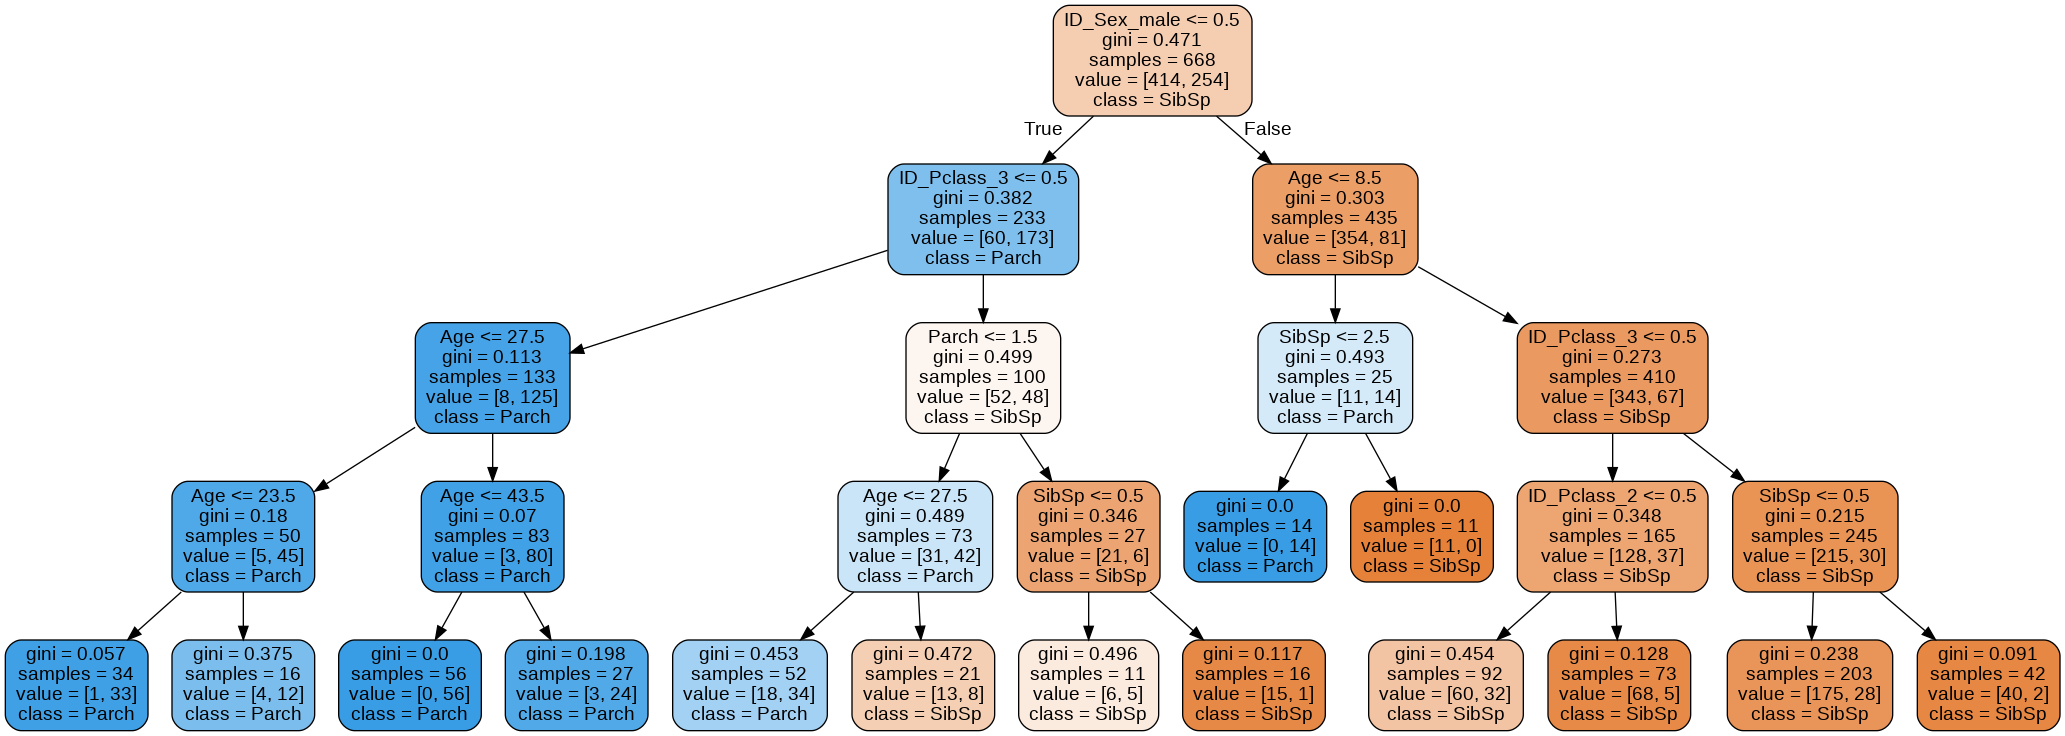

In [97]:
max_depth = gs.best_params_['max_depth']
min_samples_leaf = gs.best_params_['min_samples_leaf']
tree_clf = tree_train(X_train, y_train, X_test, y_test, max_depth = max_depth, min_samples_leaf = min_samples_leaf, features = features)


dot_data = StringIO()

export_graphviz(tree_clf, 
                out_file=dot_data,
                class_names = features,
                feature_names = features,
                rounded=True,
                filled=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('graph.png')
Image(graph.create_png())

### PREDYKCJA

In [100]:
predictions2 = tree_clf.predict(X_prediction)
predictions = predictions2.astype(int)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('titanic_{}.csv'.format(get_time()), index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
